In [250]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [251]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [252]:
filepath = "/content/song.mp3"

waveform, sample_rate = torchaudio.load(filepath)

waveform = waveform.mean(dim=0)

waveform = (waveform / waveform.abs().max())

t = torch.linspace(0, waveform.shape[0] / sample_rate, waveform.shape[0])

#plt.figure(figsize=(12, 8))
#plt.plot(t.numpy(), waveform.numpy())
#plt.tight_layout()
#plt.show()

waveform.shape

torch.Size([7803648])

In [253]:
sample_size = 1024

num_chunks = len(waveform) // sample_size
samples = waveform[:num_chunks*sample_size].view(-1, sample_size)
t_samples = t[:num_chunks*sample_size].view(-1, sample_size)

print(f"{samples.shape[0]} samples of size {samples.shape[1]}")


7620 samples of size 1024


In [254]:
# We obtain the dataset by applying welch to every sample
from scipy.signal import welch

nperseg = sample_size // 2    # Length of each segment
noverlap = nperseg // 2       # Number of overlapping samples

f, Pxx = welch(samples, sample_rate, nperseg=nperseg, noverlap=noverlap)

PSDs = torch.tensor(Pxx)
PSDs = (PSDs - PSDs.min()) / (PSDs.max() - PSDs.min()) # [0, 1] Normalization

samples.shape, PSDs.shape, f.shape

(torch.Size([7620, 1024]), torch.Size([7620, 257]), (257,))

In [255]:
# Train / Validation / Test split 80/10/10

total_size = samples.size(0)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Generate random indices for splitting
indices = torch.randperm(total_size)

# Split the data and target tensors
train_data = samples[indices[:train_size]]
val_data = samples[indices[train_size:train_size+val_size]]
test_data = samples[indices[train_size+val_size:]]

train_target = PSDs[indices[:train_size]]
val_target = PSDs[indices[train_size:train_size+val_size]]
test_target = PSDs[indices[train_size+val_size:]]


In [256]:
# Model Architecture

hidden_size = 16
output_size = noverlap + 1

# MLP  InputLayer (Signal) -> 1 HiddenLayer -> OutputLayer (PSD)

# Weights
W1 = torch.randn([sample_size, hidden_size])
W2 = torch.randn([hidden_size, hidden_size])
W3 = torch.randn([hidden_size,  output_size])

# Biases
b1 = torch.randn(hidden_size)
b2 = torch.randn(hidden_size)
b3 = torch.randn(output_size)

parameters = [W1, W2, W3, b1, b2, b3]

print("Parameter count:", sum(param.nelement() for param in parameters))

# Enable Autograd for the parameters

for param in parameters:
  param.requires_grad = True

Parameter count: 21041


In [257]:
# Training the Model

from torch.nn import MSELoss, Sigmoid

# Loss function
mse = MSELoss()

# Non-Linearity
nl = Sigmoid()

epochs = 150
lr = 1  # Learning Rate

# Tracking the loss over time
lossi = []
stepi = []
val_lossi = []

for i in range(epochs):
  ix = torch.randint(0, train_data.shape[0], (50,))  # Batches of 50

  layer1 = nl(train_data[ix] @ W1 + b1)
  layer2 = nl(layer1 @ W2 + b2)
  out = layer2 @ W3 + b3

  loss = mse(out, train_target[ix])

  if i % 5 == 0:
    # Calculate validation loss
    with torch.no_grad():
      val_layer1 = nl(val_data @ W1 + b1)
      val_layer2 = nl(val_layer1 @ W2 + b2)
      val_out = val_layer2 @ W3 + b3
      val_loss = mse(val_out, val_target)

    print(f"Epoch: {i}, Training MSE: {loss.item():.4f}, Validation MSE: {val_loss.item():.4f}")
    stepi.append(i)
    lossi.append(loss.item())
    val_lossi.append(val_loss.item())

  # Zero-Grad
  for param in parameters:
    param.grad = None

  loss.backward()

  # Parameter Update
  for param in parameters:
    param.data += -lr * param.grad

# Calculate test loss
with torch.no_grad():
    test_layer1 = nl(test_data @ W1 + b1)
    test_layer2 = nl(test_layer1 @ W2 + b2)
    test_out = test_layer2 @ W3 + b3
    test_loss = mse(test_out, test_target)

print(f"\nFinal Training MSE: {loss.item():.4f}")
print(f"Final Validation MSE: {val_loss.item():.4f}")
print(f"Final Test MSE: {test_loss.item():.4f}")

Epoch: 0, Training MSE: 6.8752, Validation MSE: 6.9258
Epoch: 5, Training MSE: 2.0662, Validation MSE: 2.1159
Epoch: 10, Training MSE: 1.1921, Validation MSE: 1.2707
Epoch: 15, Training MSE: 0.9972, Validation MSE: 1.0374
Epoch: 20, Training MSE: 0.8986, Validation MSE: 0.9086
Epoch: 25, Training MSE: 0.8064, Validation MSE: 0.8191
Epoch: 30, Training MSE: 0.7429, Validation MSE: 0.7473
Epoch: 35, Training MSE: 0.6892, Validation MSE: 0.6872
Epoch: 40, Training MSE: 0.6318, Validation MSE: 0.6345
Epoch: 45, Training MSE: 0.5799, Validation MSE: 0.5871
Epoch: 50, Training MSE: 0.5298, Validation MSE: 0.5443
Epoch: 55, Training MSE: 0.5013, Validation MSE: 0.5052
Epoch: 60, Training MSE: 0.4604, Validation MSE: 0.4690
Epoch: 65, Training MSE: 0.4351, Validation MSE: 0.4356
Epoch: 70, Training MSE: 0.4010, Validation MSE: 0.4053
Epoch: 75, Training MSE: 0.3750, Validation MSE: 0.3769
Epoch: 80, Training MSE: 0.3468, Validation MSE: 0.3507
Epoch: 85, Training MSE: 0.3304, Validation MSE: 0

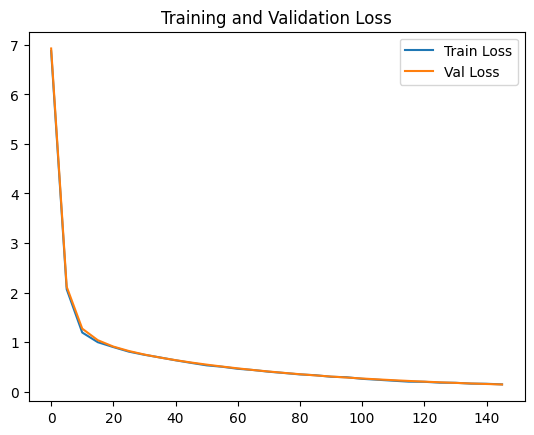

In [258]:
plt.title("Training and Validation Loss")
plt.plot(stepi, lossi, label="Train Loss")
plt.plot(stepi, val_lossi, label="Val Loss")
plt.legend()
plt.show()

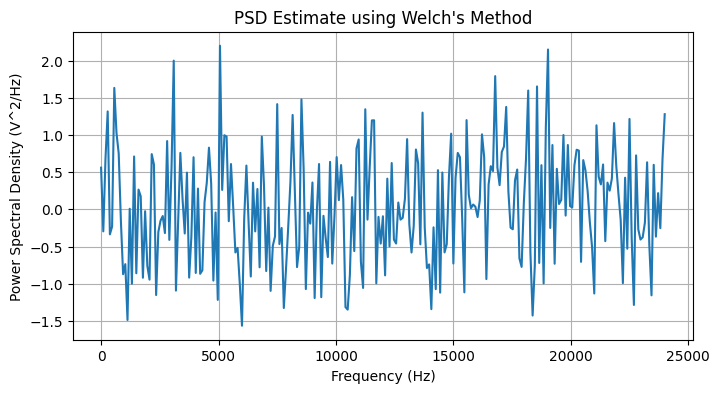

In [259]:
# Testing the model with a pure sine wave

fs = sample_size                            # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
f1, f2 = 50, 200  # Frequencies of the sinusoids (Hz)
noise_std = 0.5  # Standard deviation of the noise
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

layer1 = nl(torch.tensor(signal, dtype=torch.float32) @ W1 + b1)
layer2 = nl(layer1 @ W2 + b2)
out = layer2 @ W3 + b3

# Plot the PSD estimate
plt.figure(figsize=(8, 4))
plt.plot(f, out.detach().numpy())
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('PSD Estimate using Welch\'s Method')
plt.grid(True)
plt.show()

